In [ ]:
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2020-05-19 22:22:26--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.179.85
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.179.85|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [ ]:
import gensim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors

import nltk
from nltk.stem import WordNetLemmatizer 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV

In [ ]:
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz' # from above
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
word2vec.most_similar(positive=['woman', 'driven'], negative=['man'])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('Driven', 0.5362804532051086),
 ('ACCIDENT_Vehicles', 0.4833276867866516),
 ('fueled', 0.4749363660812378),
 ('CRASH_Vehicles', 0.44330620765686035),
 ('spurred', 0.42123943567276),
 ('stimulated', 0.3996387720108032),
 ('Nissan_Murano_crossover', 0.39866846799850464),
 ('underpinned', 0.391545832157135),
 ('propelled', 0.38335925340652466),
 ('motivated', 0.38267719745635986)]

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving negative-words.txt to negative-words.txt
Saving positive-words.txt to positive-words.txt


In [ ]:
file_name1 = "negative-words.txt"
file_name2 = "positive-words.txt"
uploaded[file_name1].decode("windows-1252")
uploaded[file_name2].decode("windows-1252")

In [ ]:
negdata = uploaded[file_name1].decode("windows-1252").split("\r\n")
print("Length of negative words:", len(negdata))

posdata_init = uploaded[file_name2].decode("windows-1252").split("\r\n")
print("Length of positive words:",len(posdata_init))

wordvec_length = 300

Length of negative words: 4784
Length of positive words: 2007


# Word2Vec

In [ ]:
# Function for creating the DataSet
def DataPrep(negdata, posdata):
  # negative
  negdata=np.asarray(negdata)
  print("\nNegative sentiment data: ", negdata)

  label_negdata = np.zeros(negdata.shape)
  for i in range(len(negdata)):
    label_negdata[i] = 1 
  print("Label for Negative sentiment : ",label_negdata[0])

  # positive 
  posdata=np.asarray(posdata)
  print("\nPositive sentiment data: ", posdata)

  label_posdata = np.zeros(posdata.shape)
  for i in range(len(posdata)):
    label_posdata[i] = 0 
  print("Label for Negative sentiment : ",label_posdata[0])

  #Combining the two datasets
  label_comb_data = np.concatenate((label_negdata, label_posdata))
  #print(label_comb_data.shape)

  comb_data = np.concatenate((negdata,posdata))
  print("\nLength of combined data: ", len(comb_data))

  return comb_data,label_comb_data

In [ ]:
# Function for Retrieving word vectors for words present in the GoogleNews-vectors-negative300 model's vocabulary  

def Retrieve_Vectors(comb_data,label_comb_data):
  j =0 
  #wordvec_length = 300
  missing = []
  present = []
  sd = np.zeros((len(comb_data), wordvec_length))
  label_sd = np.zeros(len(comb_data))

  for i in range(len(comb_data)):
    if comb_data[i] in word2vec.vocab: 
      sd[j] = word2vec[comb_data[i]] #if present copy vector
      present.append((int(i),int(j), comb_data[i])) #log of words missing in vocab
      label_sd[j] = label_comb_data[i] #if present copy vector label
      j+=1
    else:
      missing.append((i, comb_data[i]))
      #print(comb_data[i])
  print("Number of words not present in model : ",len(missing))
  print("Number of word vectors retrieved from model : ",len(present))
  # Final data set
  SentiData = sd[0:j,:]
  # print(SentiData.shape)
  label_SentiData = label_sd[0:j]
  #print(label_SentiData.shape)
  return SentiData, label_SentiData

In [ ]:
"""def Test_Vector_W2V(demo):
  i=0
  demo_vecs = np.zeros((len(demo),wordvec_length ))
  for word in demo:
    if word in word2vec.vocab:
      demo_vecs[i] = word2vec[word]
      i += 1"""

In [ ]:
def Negative_Sentiment(SentiData, label_SentiData, LRmodel):
  x_train, x_test, y_train, y_test = train_test_split(SentiData, label_SentiData, test_size = 0.3)

  if LRmodel == "StdLogReg":
    print("Std Logistic Regression ")
    LogReg = LogisticRegression()
    LogReg.fit(x_train, y_train )

    #Retrive word vectors for demographic words
    i=0
    demo_vecs = np.zeros((len(demo),wordvec_length ))
    for word in demo:
      if word in word2vec.vocab:
        demo_vecs[i] = word2vec[word]
        i += 1

    # Predict sentiment of demographic words
    predict_demo = LogReg.predict_proba(demo_vecs)
    labels = LogReg.predict(demo_vecs)
    print("Predictions : ")
    print('{:<20s}{:>20s}{:^20s}'.format("Demographic word","Negative Sentiment","Label"))
    for i in range(len(demo)):
      #print(demo[i], '\t: ', round(predict_demo[i][1], 3), "\t label: ",labels[i]) 
      print('{:<20}{:^30}{:<20d}'.format(demo[i], round(predict_demo[i][1], 3), int(labels[i])))

    neg_association=[]
    for i in range(len(demo)):
      neg_association.append( round(predict_demo[i][1], 3))
    
    
    #print(neg_association)
  
  ############################################################################

  elif LRmodel == "LassoReg": 
    print("Lasso Regression ")
    LassoReg = Lasso(alpha=0.001)
    LassoReg.fit(x_train, y_train )

    #Retrive word vectors for demographic words
    i=0
    demo_vecs = np.zeros((len(demo),wordvec_length))
    for word in demo:
      if word in word2vec.vocab:
        demo_vecs[i] = word2vec[word]
        i += 1

    # Predict sentiment of demographic words
    predict_demo = LassoReg.predict(demo_vecs)
    #labels = LassoReg.predict(demo_vecs)

    print("Predictions : ")
    print('{:<20s}{:>20s}'.format("Demographic word","Negative Sentiment"))
    for i in range(len(demo)):
      #print(demo[i], '\t: ', round(predict_demo[i][1], 3), "\t label: ",labels[i]) 
      print('{:<20}{:^30}'.format(demo[i], round(predict_demo[i], 3)))

    neg_association=[]
    for i in range(len(demo)):
      neg_association.append(round(predict_demo[i], 3))
    #print(neg_association)

  ############################################################################
  #Retrive word vectors for demographic words
  elif LRmodel == "LassoRegCV": 
    print("Lasso Regression CV ")
    LassoRegCV = LassoCV(cv= 5 )
    LassoRegCV.fit(x_train, y_train )

    i=0
    demo_vecs = np.zeros((len(demo),wordvec_length))
    for word in demo:
      if word in word2vec.vocab:
        demo_vecs[i] = word2vec[word]
        i += 1

    # Predict sentiment of demographic words
    predict_demo = LassoRegCV.predict(demo_vecs)
    #labels = LassoReg.predict(demo_vecs)

    print("Predictions : ")
    print('{:<20s}{:>20s}'.format("Demographic word","Negative Sentiment"))
    for i in range(len(demo)):
      print('{:<20}{:^30}'.format(demo[i], round(predict_demo[i], 3)))

    neg_association=[]
    for i in range(len(demo)):
      neg_association.append(round(predict_demo[i], 3))
    #print(neg_association)

  total = sum(neg_association)
  #print(sum)
  U = np.array([1/(len(demo))]*len(demo))
  for i in range(len(demo)):
    neg_association[i] = neg_association[i] / total
  return neg_association

In [ ]:
demo = ['swedish', 'irish', 'mexican','chinese','filipino','german','english','french','norwegian','american','indian','dutch','russian','scottish','italian']
#demo = ['gay', 'awful', 'beautiful', 'transgender', 'lesbian', 'sex', 'bisexual','pansexual']

## With Upsampled Data

In [ ]:
# Upsampling Positive sentiment dataset 
posdata= posdata_init + posdata_init
print("Length of upsampled positive words:",len(posdata))

# For upsampled data
comb_data,label_comb_data = DataPrep(negdata, posdata)


Length of upsampled positive words: 4014

Negative sentiment data:  ['2-faced' '2-faces' 'abnormal' ... 'zealously' 'zombie' '']
Label for Negative sentiment :  1.0

Positive sentiment data:  ['a+' 'abound' 'abounds' ... 'zest' 'zippy' '']
Label for Negative sentiment :  0.0

Length of combined data:  8798


In [ ]:
# Retrieving word vectors
SentiData, label_SentiData = Retrieve_Vectors(comb_data, label_comb_data)

Number of words not present in model :  639
Number of word vectors retrieved from model :  8159


### Std Logistic Regression

Std Logistic Regression 
Predictions : 
Demographic word      Negative Sentiment       Label        
swedish                         0.899             1                   
irish                           0.532             1                   
mexican                         0.746             1                   
chinese                         0.355             0                   
filipino                         0.24             0                   
german                          0.048             0                   
english                         0.546             1                   
french                          0.044             0                   
norwegian                       0.703             1                   
american                        0.603             1                   
indian                          0.462             0                   
dutch                           0.936             1                   
russian                         0.605          

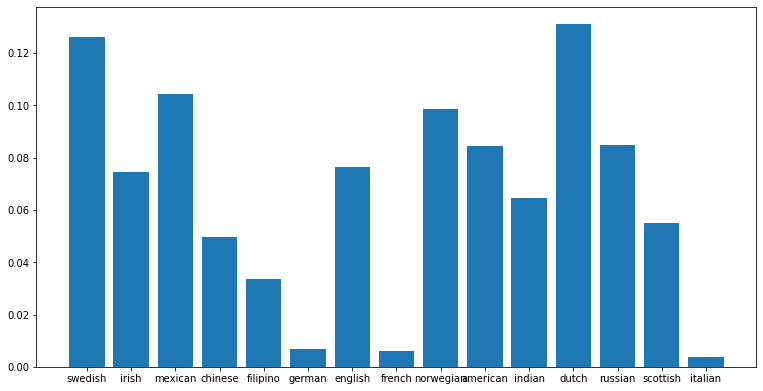

 RNSB =  0.22275406118082142


In [ ]:
# Training the Logistic Regression model and Predicting Negative sentiment for demographic words
neg_association = Negative_Sentiment(SentiData, label_SentiData, LRmodel="StdLogReg")

fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])

ax.bar(demo,neg_association)
plt.show()

#U = np.array([1/(len(demo))]*len(demo))
P= neg_association
RNSB =  sum(P * np.log(P/U))
print(" RNSB = ", RNSB)

### Lasso Regression

Lasso Regression 
Predictions : 
Demographic word      Negative Sentiment
swedish                          0.67             
irish                           0.487             
mexican                         0.619             
chinese                         0.551             
filipino                        0.403             
german                          0.365             
english                         0.596             
french                           0.31             
norwegian                       0.659             
american                        0.619             
indian                          0.575             
dutch                           0.632             
russian                         0.671             
scottish                         0.48             
italian                         0.252             


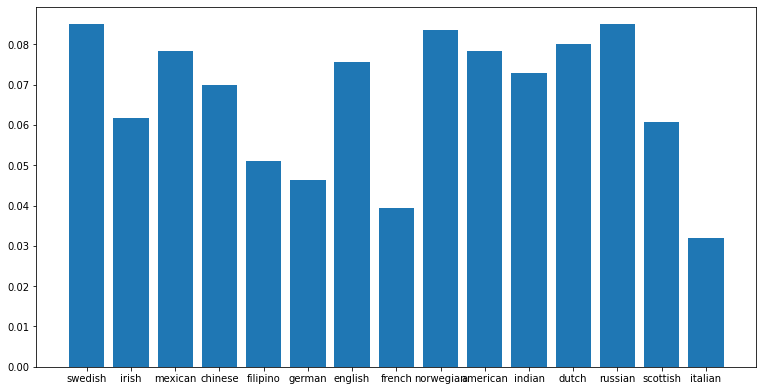

 RNSB =  [ 0.02056144 -0.00474779  0.01278415  0.00325196 -0.01360044 -0.01690026
  0.00944853 -0.02077154  0.01884102  0.01278415  0.00650114  0.01471769
  0.02071898 -0.00556045 -0.02350207]


In [ ]:
# Training the Logistic Regression model and Predicting Negative sentiment for demographic words
neg_association = Negative_Sentiment(SentiData, label_SentiData, LRmodel="LassoReg")


fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])

ax.bar(demo,neg_association)
plt.show()
#print(U)

U = np.array([1/(len(demo))]*len(demo))
P= neg_association
RNSB =  (P * np.log(P/U))
print(" RNSB = ", RNSB)

### LassoCV

Lasso Regression CV 
Predictions : 
Demographic word      Negative Sentiment
swedish                          0.74             
irish                           0.545             
mexican                         0.642             
chinese                         0.648             
filipino                        0.402             
german                          0.308             
english                         0.666             
french                          0.418             
norwegian                       0.645             
american                        0.625             
indian                          0.637             
dutch                           0.734             
russian                         0.701             
scottish                        0.589             
italian                         0.321             


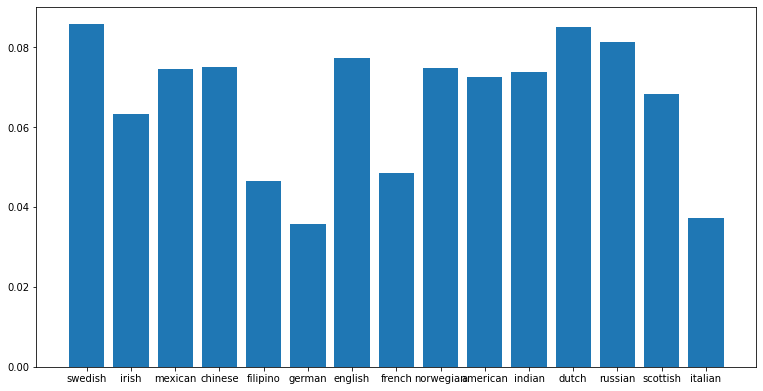

In [ ]:
# Training the Logistic Regression model and Predicting Negative sentiment for demographic words
neg_association = Negative_Sentiment(SentiData, label_SentiData, LRmodel="LassoRegCV")
U = np.array([1/(len(demo))]*len(demo))

fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])

ax.bar(demo,neg_association)
plt.show()

#### RNSB

In [ ]:
U = np.array([1/(len(demo))]*len(demo))
P= neg_association
RNSB = sum (P * np.log(P/U))
print(" RNSB = ", RNSB)

 RNSB =  0.031860413568441714


## With Unequal Ratios

In [ ]:
negdata = uploaded[file_name1].decode("windows-1252").split("\r\n")
print("Length of negative words:", len(negdata))

posdata = uploaded[file_name2].decode("windows-1252").split("\r\n")
print("Length of positive words:",len(posdata_init))

wordvec_length = 300

Length of negative words: 4784
Length of positive words: 2007


In [ ]:
# For upsampled data
comb_data,label_comb_data = DataPrep(negdata, posdata)



Negative sentiment data:  ['2-faced' '2-faces' 'abnormal' ... 'zealously' 'zombie' '']
Label for Negative sentiment :  1.0

Positive sentiment data:  ['a+' 'abound' 'abounds' ... 'zest' 'zippy' '']
Label for Negative sentiment :  0.0

Length of combined data:  6791


In [ ]:
# Retrieving word vectors
SentiData, label_SentiData = Retrieve_Vectors(comb_data, label_comb_data)

Number of words not present in model :  489
Number of word vectors retrieved from model :  6302


### Std Logistic Regression

Std Logistic Regression 
Predictions : 
Demographic word      Negative SentimentLabel               
swedish                          0.8              1                   
irish                           0.203             0                   
mexican                         0.886             1                   
chinese                         0.468             0                   
filipino                        0.196             0                   
german                          0.015             0                   
english                         0.297             0                   
french                          0.017             0                   
norwegian                       0.478             0                   
american                        0.422             0                   
indian                          0.511             1                   
dutch                           0.884             1                   
russian                         0.451          

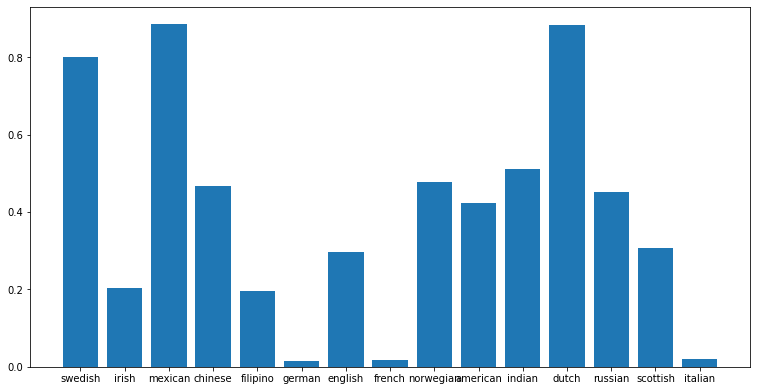

In [ ]:
# Training the Logistic Regression model and Predicting Negative sentiment for demographic words
neg_association = Negative_Sentiment(SentiData, label_SentiData, LRmodel="StdLogReg")


fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])

ax.bar(demo,neg_association)
plt.show()

### Lasso Regression

Lasso Regression 
Predictions : 
Demographic word      Negative Sentiment
swedish                         0.822             
irish                           0.546             
mexican                         0.656             
chinese                         0.654             
filipino                        0.474             
german                          0.513             
english                         0.591             
french                          0.378             
norwegian                       0.743             
american                        0.686             
indian                          0.626             
dutch                           0.663             
russian                         0.732             
scottish                        0.535             
italian                         0.388             


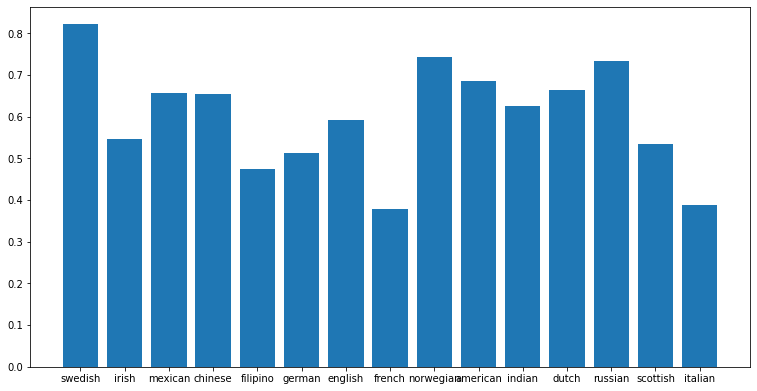

In [ ]:
# Training the Logistic Regression model and Predicting Negative sentiment for demographic words
neg_association = Negative_Sentiment(SentiData, label_SentiData, LRmodel="LassoReg")

fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])

ax.bar(demo,neg_association)
plt.show()

### LassoCV

Lasso Regression CV 
Predictions : 
Demographic word      Negative Sentiment
swedish                         0.851             
irish                           0.591             
mexican                         0.737             
chinese                         0.689             
filipino                        0.431             
german                          0.516             
english                         0.659             
french                          0.436             
norwegian                       0.679             
american                        0.646             
indian                          0.626             
dutch                           0.814             
russian                         0.749             
scottish                         0.61             
italian                         0.388             


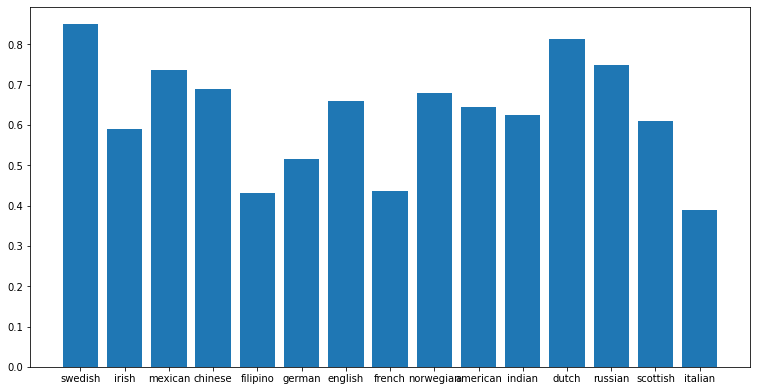

In [ ]:
# Training the Logistic Regression model and Predicting Negative sentiment for demographic words
neg_association = Negative_Sentiment(SentiData, label_SentiData, LRmodel="LassoRegCV")


fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])

ax.bar(demo,neg_association)
plt.show()

## LGBTQ+ Terms

In [ ]:
demo =['lesbian', 'gay', 'bisexual', 'transgender', 'heterosexism' , 'homophobia', 'biphobia', 'transphobia' ,'subcultures', 'androgynous', 'asexual',
             'cisgender','closeted','drag','heterosexual ','homosexual','intersex','pansexual','queer']
len(demo)

19

In [ ]:
# Upsampling Positive sentiment dataset 
posdata= posdata_init + posdata_init
print("Length of upsampled positive words:",len(posdata))

# For upsampled data
comb_data,label_comb_data = DataPrep(negdata, posdata)


Length of upsampled positive words: 4014

Negative sentiment data:  ['2-faced' '2-faces' 'abnormal' ... 'zealously' 'zombie' '']
Label for Negative sentiment :  1.0

Positive sentiment data:  ['a+' 'abound' 'abounds' ... 'zest' 'zippy' '']
Label for Negative sentiment :  0.0

Length of combined data:  8798


In [ ]:
# Retrieving word vectors
SentiData, label_SentiData = Retrieve_Vectors(comb_data, label_comb_data)

Number of words not present in model :  639
Number of word vectors retrieved from model :  8159


### Std Logistic Regression

Std Logistic Regression 
Predictions : 
Demographic word      Negative SentimentLabel               
lesbian                         0.952             1                   
gay                             0.984             1                   
bisexual                        0.914             1                   
transgender                     0.923             1                   
heterosexism                    0.999             1                   
homophobia                      0.999             1                   
biphobia                        0.784             1                   
transphobia                     0.996             1                   
subcultures                     0.746             1                   
androgynous                     0.899             1                   
asexual                         0.903             1                   
cisgender                       0.976             1                   
closeted                        0.997          

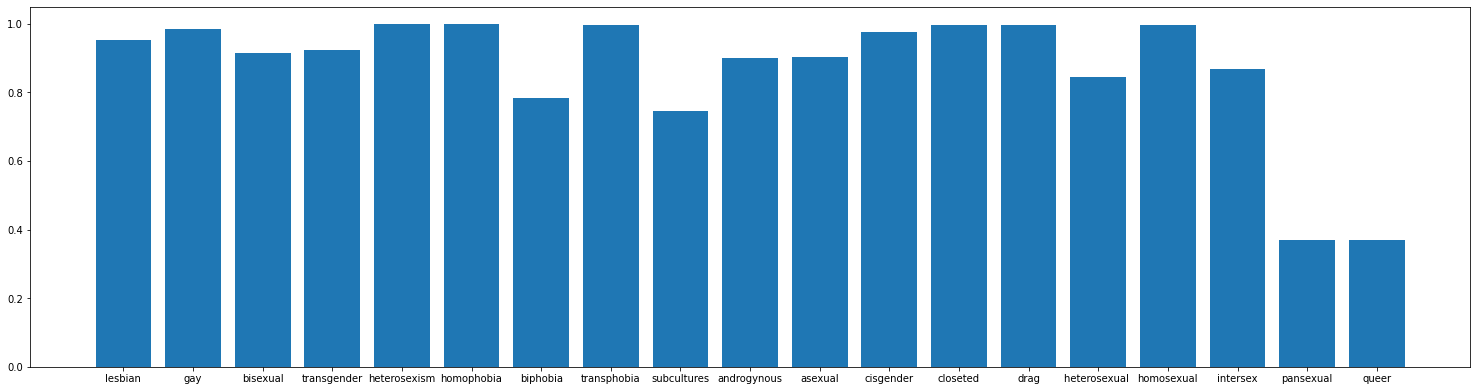

In [ ]:
# Training the Logistic Regression model and Predicting Negative sentiment for demographic words
neg_association = Negative_Sentiment(SentiData, label_SentiData, LRmodel="StdLogReg")


fig = plt.figure(figsize=(20,5))
ax = fig.add_axes([0,0,1,1])

ax.bar(demo,neg_association)
plt.show()

### Lasso Regression

Lasso Regression 
Predictions : 
Demographic word      Negative Sentiment
lesbian                         0.722             
gay                             0.714             
bisexual                        0.676             
transgender                     0.594             
heterosexism                    0.897             
homophobia                      0.994             
biphobia                        0.578             
transphobia                     0.779             
subcultures                     0.581             
androgynous                     0.535             
asexual                         0.634             
cisgender                       0.767             
closeted                        0.928             
drag                            0.914             
heterosexual                    0.673             
homosexual                      0.848             
intersex                        0.569             
pansexual                        0.43             
queer   

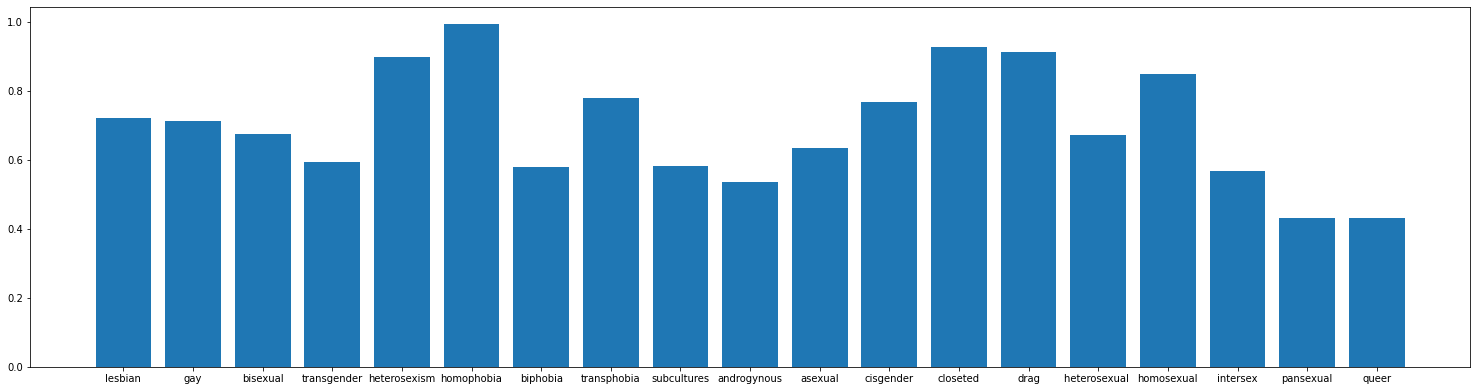

In [ ]:
# Training the Logistic Regression model and Predicting Negative sentiment for demographic words
neg_association = Negative_Sentiment(SentiData, label_SentiData, LRmodel="LassoReg")

fig = plt.figure(figsize=(20,5))
ax = fig.add_axes([0,0,1,1])

ax.bar(demo,neg_association)
plt.show()

### LassoCV

Lasso Regression CV 
Predictions : 
Demographic word      Negative Sentiment
lesbian                         0.712             
gay                             0.773             
bisexual                        0.696             
transgender                     0.632             
heterosexism                     0.91             
homophobia                      0.995             
biphobia                        0.567             
transphobia                     0.734             
subcultures                     0.567             
androgynous                     0.527             
asexual                         0.691             
cisgender                       0.823             
closeted                        0.985             
drag                            0.978             
heterosexual                    0.687             
homosexual                       0.88             
intersex                        0.608             
pansexual                       0.465             
queer

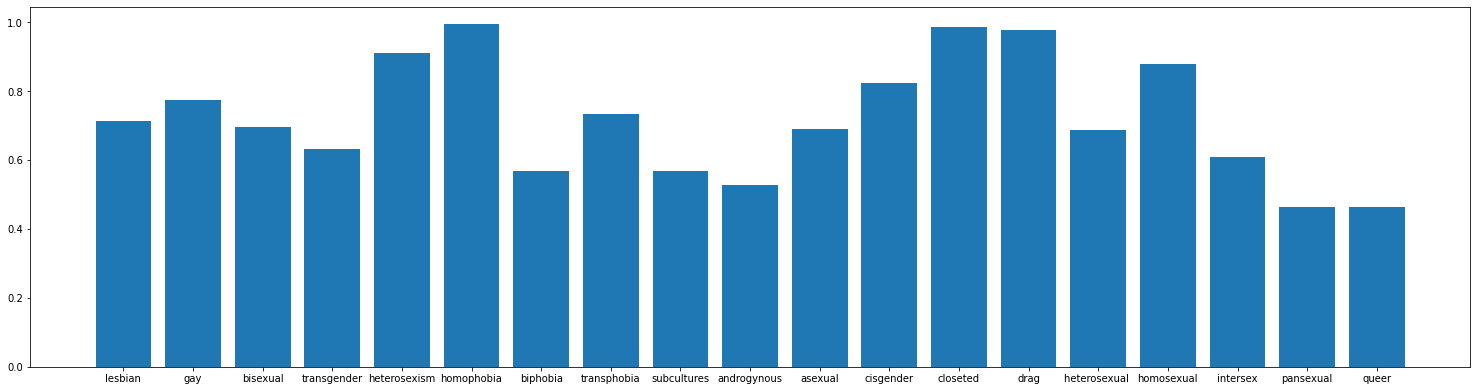

In [ ]:
# Training the Logistic Regression model and Predicting Negative sentiment for demographic words
neg_association = Negative_Sentiment(SentiData, label_SentiData, LRmodel="LassoRegCV")


fig = plt.figure(figsize=(20,5))
ax = fig.add_axes([0,0,1,1])

ax.bar(demo,neg_association)
plt.show()

# concept net

In [ ]:
!wget https://conceptnet.s3.amazonaws.com/downloads/2017/numberbatch/numberbatch-17.06.txt.gz
!gunzip numberbatch-17.06.txt.gz
from gensim.models.keyedvectors import KeyedVectors
numberbatch = KeyedVectors.load_word2vec_format("numberbatch-17.06.txt", binary=False)


In [ ]:
numberbatch["/c/en/tea_kettle"]

In [ ]:
#Retrive word vectors for demographic words
def Test_Vector(demo):
    i=0
    demo_vecs = np.zeros((len(demo),wordvec_length ))
    for i in range(len(demo)):
      X = "/c/en/"+demo[i]
      if X in numberbatch.vocab:
        demo_vecs[i] = numberbatch[X]
        print(X)
    return demo_vecs
        
   

In [ ]:
def Negative_Sentiment(SentiData, label_SentiData, LRmodel):
  x_train, x_test, y_train, y_test = train_test_split(SentiData, label_SentiData, test_size = 0.3)

  demo_vecs = Test_Vector(demo)
  if LRmodel == "StdLogReg":
    print("Std Logistic Regression ")
    LogReg = LogisticRegression()
    LogReg.fit(x_train, y_train )

    

    # Predict sentiment of demographic words
    predict_demo = LogReg.predict_proba(demo_vecs)
    labels = LogReg.predict(demo_vecs)
    print("Predictions : ")
    print('{:<20s}{:>20s}{:^20s}'.format("Demographic word","Negative Sentiment","Label"))
    for i in range(len(demo)):
      #print(demo[i], '\t: ', round(predict_demo[i][1], 3), "\t label: ",labels[i]) 
      print('{:<20}{:^30}{:<20d}'.format(demo[i], round(predict_demo[i][1], 3), int(labels[i])))

    neg_association=[]
    for i in range(len(demo)):
      neg_association.append( round(predict_demo[i][1], 3))
    
    
    #print(neg_association)
  
  ############################################################################

  elif LRmodel == "LassoReg": 
    print("Lasso Regression ")
    LassoReg = Lasso(alpha=0.001)
    LassoReg.fit(x_train, y_train )

    
    # Predict sentiment of demographic words
    predict_demo = LassoReg.predict(demo_vecs)
    #labels = LassoReg.predict(demo_vecs)

    print("Predictions : ")
    print('{:<20s}{:>20s}'.format("Demographic word","Negative Sentiment"))
    for i in range(len(demo)):
      #print(demo[i], '\t: ', round(predict_demo[i][1], 3), "\t label: ",labels[i]) 
      print('{:<20}{:^30}'.format(demo[i], round(predict_demo[i], 3)))

    neg_association=[]
    for i in range(len(demo)):
      neg_association.append(round(predict_demo[i], 3))
    #print(neg_association)

  ############################################################################
  #Retrive word vectors for demographic words
  elif LRmodel == "LassoRegCV": 
    print("Lasso Regression CV ")
    LassoRegCV = LassoCV(cv= 5 )
    LassoRegCV.fit(x_train, y_train )

    # Predict sentiment of demographic words
    predict_demo = LassoRegCV.predict(demo_vecs)
    #labels = LassoReg.predict(demo_vecs)

    print("Predictions : ")
    print('{:<20s}{:>20s}'.format("Demographic word","Negative Sentiment"))
    for i in range(len(demo)):
      print('{:<20}{:^30}'.format(demo[i], round(predict_demo[i], 3)))

    neg_association=[]
    for i in range(len(demo)):
      neg_association.append(round(predict_demo[i], 3))
    #print(neg_association)

  total = sum(neg_association)
  #print(sum)
  U = np.array([1/(len(demo))]*len(demo))
  for i in range(len(demo)):
    neg_association[i] = neg_association[i] / total
  return neg_association

In [ ]:
def Retrieve_Vectors_CN(comb_data,label_comb_data):
  j=0 
  #wordvec_length = 300
  missing = []
  present = []
  sd = np.zeros((len(comb_data), wordvec_length))
  label_sd = np.zeros(len(comb_data))

  for i in range(len(comb_data)):
    X = "/c/en/"+comb_data[i]
    if X in numberbatch.vocab:
      sd[j] = numberbatch[X] #if present copy vector
      present.append((int(i),int(j), comb_data[i])) #log of words missing in vocab
      label_sd[j] = label_comb_data[i] #if present copy vector label
      j+=1
    else:
      missing.append((i, comb_data[i]))
      #print(comb_data[i])
  print("Number of words not present in model : ",len(missing))
  print("Number of word vectors retrieved from model : ",len(present))
  # Final data set
  SentiData = sd[0:j,:]
  # print(SentiData.shape)
  label_SentiData = label_sd[0:j]
  #print(label_SentiData.shape)
  return SentiData, label_SentiData
  


In [ ]:
#numberbatch["/c/en/comb_data[1]"]
X="word"
x = "/c/en/"+X
if x in numberbatch.vocab:
  print("ya")
#numberbatch[x]

ya


In [ ]:
negdata = uploaded[file_name1].decode("windows-1252").split("\r\n")
print("Length of negative words:", len(negdata))

posdata_init = uploaded[file_name2].decode("windows-1252").split("\r\n")
print("Length of positive words:",len(posdata_init))

Length of negative words: 4784
Length of positive words: 2007


In [ ]:
# For upsampled data
comb_data,label_comb_data = DataPrep(negdata, posdata)



Negative sentiment data:  ['2-faced' '2-faces' 'abnormal' ... 'zealously' 'zombie' '']
Label for Negative sentiment :  1.0

Positive sentiment data:  ['a+' 'abound' 'abounds' ... 'zest' 'zippy' '']
Label for Negative sentiment :  0.0

Length of combined data:  8798


In [ ]:
# Retrieving word vectors
SentiData, label_SentiData = Retrieve_Vectors_CN(comb_data, label_comb_data)

Number of words not present in model :  695
Number of word vectors retrieved from model :  8103


## With Upsampled Data

### Std Logistic Regression

/c/en/swedish
/c/en/irish
/c/en/mexican
/c/en/chinese
/c/en/filipino
/c/en/german
/c/en/english
/c/en/french
/c/en/norwegian
/c/en/american
/c/en/indian
/c/en/dutch
/c/en/russian
/c/en/scottish
/c/en/italian
Std Logistic Regression 
Predictions : 
Demographic word      Negative Sentiment       Label        
swedish                         0.645             1                   
irish                           0.649             1                   
mexican                         0.804             1                   
chinese                         0.642             1                   
filipino                        0.593             1                   
german                          0.748             1                   
english                         0.635             1                   
french                          0.727             1                   
norwegian                        0.58             1                   
american                         0.62             1 

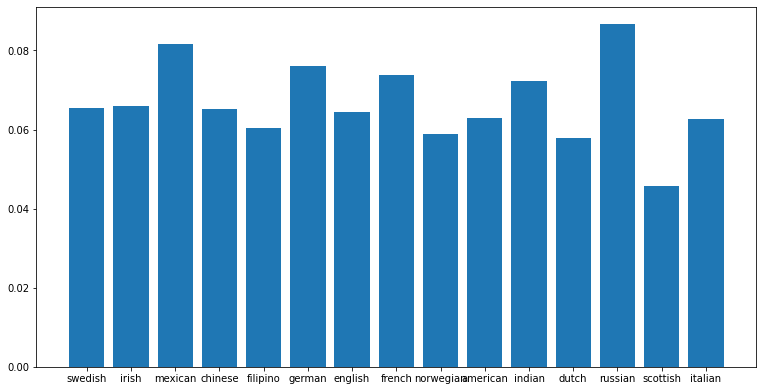

 RNSB =  0.010990917609667326


In [ ]:
# Training the Logistic Regression model and Predicting Negative sentiment for demographic words
neg_association = Negative_Sentiment(SentiData, label_SentiData, LRmodel="StdLogReg")

fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])

ax.bar(demo,neg_association)
plt.show()

#U = np.array([1/(len(demo))]*len(demo))
P= neg_association
RNSB =  sum(P * np.log(P/U))
print(" RNSB = ", RNSB)

### Lasso Regression

/c/en/swedish
/c/en/irish
/c/en/mexican
/c/en/chinese
/c/en/filipino
/c/en/german
/c/en/english
/c/en/french
/c/en/norwegian
/c/en/american
/c/en/indian
/c/en/dutch
/c/en/russian
/c/en/scottish
/c/en/italian
Lasso Regression 
Predictions : 
Demographic word      Negative Sentiment
swedish                         0.508             
irish                           0.439             
mexican                         0.579             
chinese                         0.418             
filipino                        0.533             
german                          0.502             
english                         0.423             
french                          0.474             
norwegian                       0.533             
american                         0.49             
indian                          0.495             
dutch                           0.484             
russian                         0.619             
scottish                        0.382             
ital

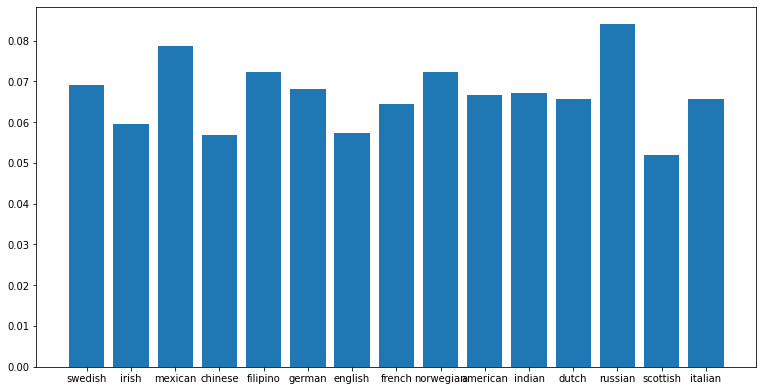

 RNSB =  0.007309755574459566


In [ ]:
# Training the Logistic Regression model and Predicting Negative sentiment for demographic words
neg_association = Negative_Sentiment(SentiData, label_SentiData, LRmodel="LassoReg")


fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])

ax.bar(demo,neg_association)
plt.show()
#print(U)

U = np.array([1/(len(demo))]*len(demo))
P= neg_association
RNSB = sum (P * np.log(P/U))
print(" RNSB = ", RNSB)

 RNSB =  0.031860413568441714


### LassoCV

/c/en/swedish
/c/en/irish
/c/en/mexican
/c/en/chinese
/c/en/filipino
/c/en/german
/c/en/english
/c/en/french
/c/en/norwegian
/c/en/american
/c/en/indian
/c/en/dutch
/c/en/russian
/c/en/scottish
/c/en/italian
Lasso Regression CV 
Predictions : 
Demographic word      Negative Sentiment
swedish                         0.565             
irish                           0.512             
mexican                         0.702             
chinese                          0.61             
filipino                        0.629             
german                          0.606             
english                         0.387             
french                          0.489             
norwegian                       0.571             
american                        0.494             
indian                          0.552             
dutch                           0.556             
russian                         0.743             
scottish                         0.49             
i

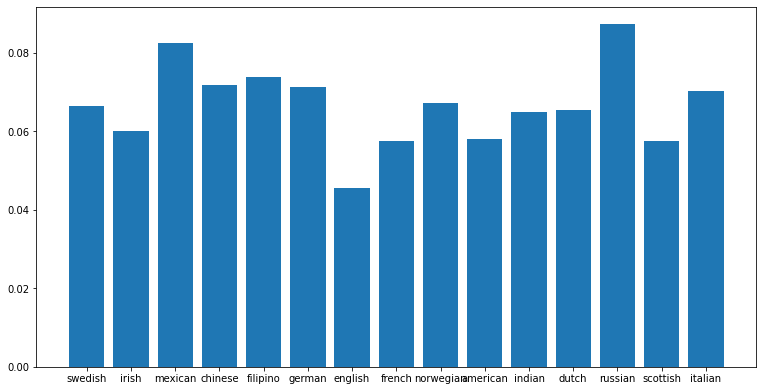

 RNSB =  0.011530731193444246


In [ ]:
# Training the Logistic Regression model and Predicting Negative sentiment for demographic words
neg_association = Negative_Sentiment(SentiData, label_SentiData, LRmodel="LassoRegCV")
U = np.array([1/(len(demo))]*len(demo))

fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])

ax.bar(demo,neg_association)
plt.show()

#U = np.array([1/(len(demo))]*len(demo))
P= neg_association
RNSB =  sum(P * np.log(P/U))
print(" RNSB = ", RNSB)

In [ ]:
U = np.array([1/(len(demo))]*len(demo))
P= neg_association
RNSB = sum (P * np.log(P/U))
print(" RNSB = ", RNSB)

 RNSB =  0.031860413568441714


# GloVe

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip


--2020-05-20 00:48:06--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-05-20 00:48:06--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-05-20 00:48:07--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
!unzip glove*.zip

Archive:  glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: glove.6B.50d.txt        
replace glove.6B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: glove.6B.100d.txt       
replace glove.6B.200d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: glove.6B.200d.txt       
replace glove.6B.300d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: glove.6B.300d.txt       


In [ ]:
!ls
!pwd

glove.6B.100d.txt  glove.6B.50d.txt    numberbatch-17.06.txt  sample_data
glove.6B.200d.txt  glove.6B.zip        numberbatch-en.txt
glove.6B.300d.txt  negative-words.txt  positive-words.txt
/content


In [ ]:
print('Indexing word vectors.')

embeddings_index = {}
f = open('glove.6B.300d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

Indexing word vectors.


In [ ]:
# Function for Retrieving word vectors for words present in the GLOVE model's vocabulary  

def Retrieve_Vectors_GV(comb_data,label_comb_data):
  j =0 
  #wordvec_length = 300
  missing = []
  present = []
  sd = np.zeros((len(comb_data), wordvec_length))
  label_sd = np.zeros(len(comb_data))

  for i in range(len(comb_data)):
    if comb_data[i] in embeddings_index: 
      sd[j] = embeddings_index[comb_data[i]] #if present copy vector
      present.append((int(i),int(j), comb_data[i])) #log of words missing in vocab
      label_sd[j] = label_comb_data[i] #if present copy vector label
      j+=1
    else:
      missing.append((i, comb_data[i]))
      #print(comb_data[i])
  print("Number of words not present in model : ",len(missing))
  print("Number of word vectors retrieved from model : ",len(present))
  # Final data set
  SentiData = sd[0:j,:]
  #print(SentiData.shape, SentiData[1])
  label_SentiData = label_sd[0:j]
  #print(label_SentiData.shape)
  return SentiData, label_SentiData

In [ ]:
if comb_data[5] in embeddings_index:
  print("yes")

yes


In [ ]:
def Negative_Sentiment_Glove(SentiData, label_SentiData, LRmodel):
  x_train, x_test, y_train, y_test = train_test_split(SentiData, label_SentiData, test_size = 0.3)

  demo_vecs = Test_Vector_GL(demo)

  if LRmodel == "StdLogReg":
    print("Std Logistic Regression ")
    LogReg = LogisticRegression()
    LogReg.fit(x_train, y_train )

    
    # Predict sentiment of demographic words
    predict_demo = LogReg.predict_proba(demo_vecs)
    labels = LogReg.predict(demo_vecs)
    print("Predictions : ")
    print('{:<20s}{:>20s}{:^20s}'.format("Demographic word","Negative Sentiment","Label"))
    for i in range(len(demo)):
      #print(demo[i], '\t: ', round(predict_demo[i][1], 3), "\t label: ",labels[i]) 
      print('{:<20}{:^30}{:<20d}'.format(demo[i], round(predict_demo[i][1], 3), int(labels[i])))

    neg_association=[]
    for i in range(len(demo)):
      neg_association.append( round(predict_demo[i][1], 3))
    
    
    #print(neg_association)
  
  ############################################################################

  elif LRmodel == "LassoReg": 
    print("Lasso Regression ")
    LassoReg = Lasso(alpha=0.001)
    LassoReg.fit(x_train, y_train )

    # Predict sentiment of demographic words
    predict_demo = LassoReg.predict(demo_vecs)
    #labels = LassoReg.predict(demo_vecs)

    print("Predictions : ")
    print('{:<20s}{:>20s}'.format("Demographic word","Negative Sentiment"))
    for i in range(len(demo)):
      #print(demo[i], '\t: ', round(predict_demo[i][1], 3), "\t label: ",labels[i]) 
      print('{:<20}{:^30}'.format(demo[i], round(predict_demo[i], 3)))

    neg_association=[]
    for i in range(len(demo)):
      neg_association.append(round(predict_demo[i], 3))
    #print(neg_association)

  ############################################################################
  #Retrive word vectors for demographic words
  elif LRmodel == "LassoRegCV": 
    print("Lasso Regression CV ")
    LassoRegCV = LassoCV(cv= 5 )
    LassoRegCV.fit(x_train, y_train )

    # Predict sentiment of demographic words
    predict_demo = LassoRegCV.predict(demo_vecs)
    #labels = LassoReg.predict(demo_vecs)

    print("Predictions : ")
    print('{:<20s}{:>20s}'.format("Demographic word","Negative Sentiment"))
    for i in range(len(demo)):
      print('{:<20}{:^30}'.format(demo[i], round(predict_demo[i], 3)))

    neg_association=[]
    for i in range(len(demo)):
      neg_association.append(round(predict_demo[i], 3))
    #print(neg_association)

  total = sum(neg_association)
  #print(sum)
  U = np.array([1/(len(demo))]*len(demo))
  for i in range(len(demo)):
    neg_association[i] = neg_association[i] / total
  return neg_association

In [ ]:
#Retrive word vectors for demographic words
def Test_Vector_GL(demo):
    i=0
    demo_vecs = np.zeros((len(demo),wordvec_length ))
    for i in range(len(demo)):
      if demo[i] in embeddings_index:
        demo_vecs[i] = embeddings_index[demo[i]]
        #print(i)
    #print(demo_vecs[1].shape, demo_vecs[1])
    return demo_vecs
        

In [ ]:
demo = ['swedish', 'irish', 'mexican','chinese','filipino','german','english','french','norwegian','american','indian','dutch','russian','scottish','italian']
#demo = ['gay', 'awful', 'beautiful', 'transgender', 'lesbian', 'sex', 'bisexual','pansexual']

## With Upsampled Data

In [ ]:
# Upsampling Positive sentiment dataset 
posdata= posdata_init + posdata_init
print("Length of upsampled positive words:",len(posdata))

# For upsampled data
comb_data,label_comb_data = DataPrep(negdata, posdata)


Length of upsampled positive words: 4014

Negative sentiment data:  ['2-faced' '2-faces' 'abnormal' ... 'zealously' 'zombie' '']
Label for Negative sentiment :  1.0

Positive sentiment data:  ['a+' 'abound' 'abounds' ... 'zest' 'zippy' '']
Label for Negative sentiment :  0.0

Length of combined data:  8798


In [ ]:
# Retrieving word vectors
SentiData, label_SentiData = Retrieve_Vectors_GV(comb_data, label_comb_data)

Number of words not present in model :  667
Number of word vectors retrieved from model :  8131


### Std Logistic Regression

Std Logistic Regression 
Predictions : 
Demographic word      Negative Sentiment       Label        
swedish                         0.022             0                   
irish                           0.102             0                   
mexican                         0.375             0                   
chinese                         0.005             0                   
filipino                        0.065             0                   
german                          0.023             0                   
english                         0.028             0                   
french                          0.059             0                   
norwegian                        0.09             0                   
american                        0.158             0                   
indian                          0.448             0                   
dutch                           0.257             0                   
russian                         0.341          

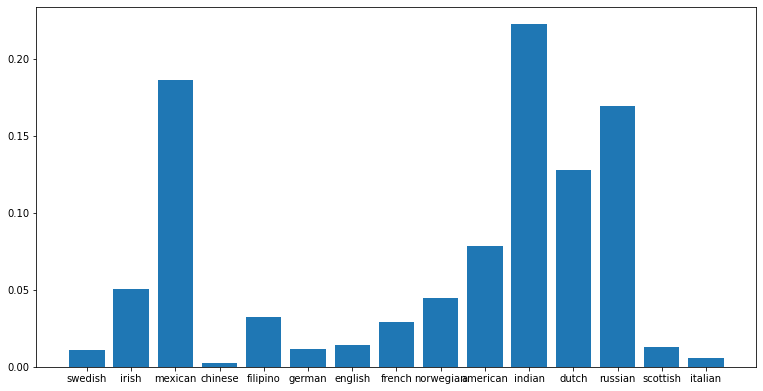

 RNSB =  0.530234023285076


In [ ]:
# Training the Logistic Regression model and Predicting Negative sentiment for demographic words
neg_association = Negative_Sentiment_Glove(SentiData, label_SentiData, LRmodel="StdLogReg")

fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])

ax.bar(demo,neg_association)
plt.show()

U = np.array([1/(len(demo))]*len(demo))
P= neg_association
RNSB =  sum(P * np.log(P/U))
print(" RNSB = ", RNSB)

### Lasso Regression

Lasso Regression 
Predictions : 
Demographic word      Negative Sentiment
swedish                         0.216             
irish                           0.229             
mexican                         0.433             
chinese                         0.074             
filipino                        0.213             
german                          0.217             
english                         0.244             
french                          0.255             
norwegian                       0.335             
american                        0.405             
indian                          0.596             
dutch                           0.316             
russian                         0.487             
scottish                        0.247             
italian                         0.116             


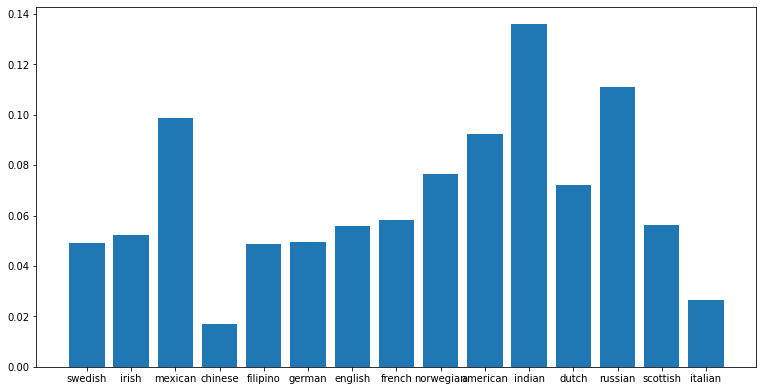

 RNSB =  0.10601185721040124


In [ ]:
# Training the Logistic Regression model and Predicting Negative sentiment for demographic words
neg_association = Negative_Sentiment_Glove(SentiData, label_SentiData, LRmodel="LassoReg")


fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])

ax.bar(demo,neg_association)
plt.show()
#print(U)

U = np.array([1/(len(demo))]*len(demo))
P= neg_association
RNSB =  sum(P * np.log(P/U))
print(" RNSB = ", RNSB)

### LassoCV

Lasso Regression CV 
Predictions : 
Demographic word      Negative Sentiment
swedish                         0.232             
irish                           0.185             
mexican                         0.425             
chinese                         0.183             
filipino                        0.204             
german                          0.239             
english                         0.183             
french                          0.198             
norwegian                       0.332             
american                        0.342             
indian                          0.484             
dutch                           0.318             
russian                         0.393             
scottish                        0.133             
italian                         0.066             


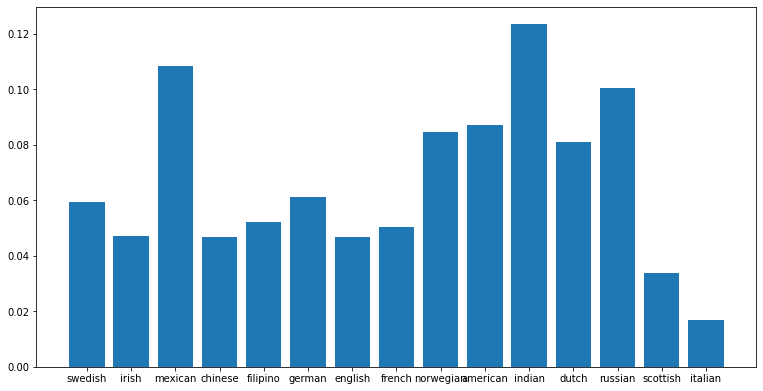

 RNSB =  0.09516269106537259


In [ ]:
# Training the Logistic Regression model and Predicting Negative sentiment for demographic words
neg_association = Negative_Sentiment_Glove(SentiData, label_SentiData, LRmodel="LassoRegCV")
U = np.array([1/(len(demo))]*len(demo))

fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])

ax.bar(demo,neg_association)
plt.show()
U = np.array([1/(len(demo))]*len(demo))
P= neg_association
RNSB =  sum(P * np.log(P/U))
print(" RNSB = ", RNSB)

## LGBT Terms

In [ ]:
demo =['lesbian', 'gay', 'bisexual', 'transgender', 'heterosexism' , 'homophobia', 'biphobia', 'transphobia' ,'subcultures', 'androgynous', 'asexual',
             'cisgender','closeted','drag','heterosexual ','homosexual','intersex','pansexual','queer']
len(demo)

19

In [ ]:
# Upsampling Positive sentiment dataset 
posdata= posdata_init + posdata_init
print("Length of upsampled positive words:",len(posdata))

# For upsampled data
comb_data,label_comb_data = DataPrep(negdata, posdata)


Length of upsampled positive words: 4014

Negative sentiment data:  ['2-faced' '2-faces' 'abnormal' ... 'zealously' 'zombie' '']
Label for Negative sentiment :  1.0

Positive sentiment data:  ['a+' 'abound' 'abounds' ... 'zest' 'zippy' '']
Label for Negative sentiment :  0.0

Length of combined data:  8798


In [ ]:
# Retrieving word vectors
SentiData, label_SentiData = Retrieve_Vectors_GV(comb_data, label_comb_data)

Number of words not present in model :  667
Number of word vectors retrieved from model :  8131


### Std Logistic Regression

Std Logistic Regression 
Predictions : 
Demographic word      Negative Sentiment       Label        
lesbian                         0.211             0                   
gay                             0.141             0                   
bisexual                        0.939             1                   
transgender                      0.62             1                   
heterosexism                    0.494             0                   
homophobia                      0.992             1                   
biphobia                        0.556             1                   
transphobia                     0.987             1                   
subcultures                     0.622             1                   
androgynous                      0.49             0                   
asexual                         0.972             1                   
cisgender                       0.877             1                   
closeted                        0.995          

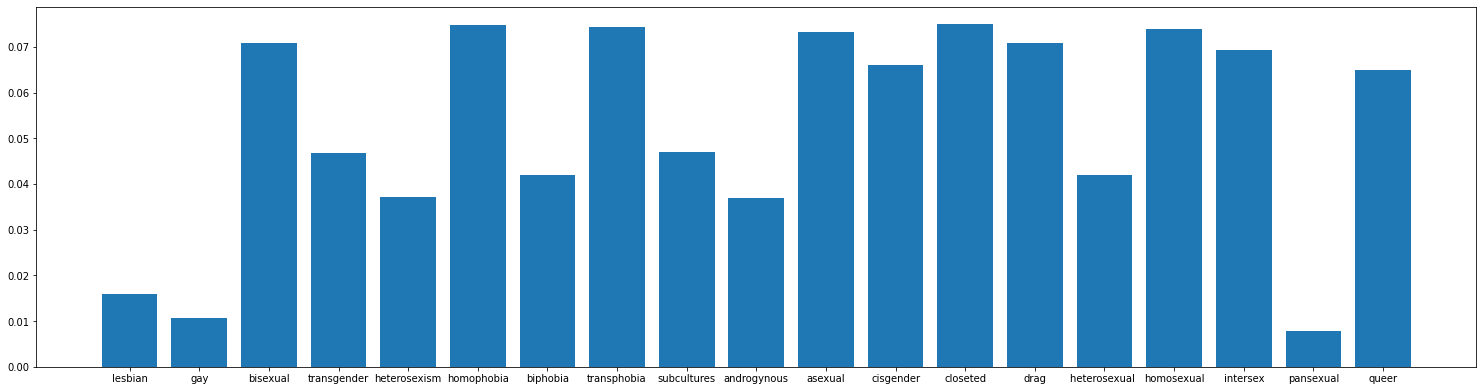

 RNSB =  0.1114734539974962


In [ ]:
# Training the Logistic Regression model and Predicting Negative sentiment for demographic words
neg_association = Negative_Sentiment_Glove(SentiData, label_SentiData, LRmodel="StdLogReg")


fig = plt.figure(figsize=(20,5))
ax = fig.add_axes([0,0,1,1])

ax.bar(demo,neg_association)
plt.show()

U = np.array([1/(len(demo))]*len(demo))
P= neg_association
RNSB =  sum(P * np.log(P/U))
print(" RNSB = ", RNSB)

### Lasso Regression

Lasso Regression 
Predictions : 
Demographic word      Negative Sentiment
lesbian                         0.417             
gay                             0.571             
bisexual                        0.785             
transgender                     0.653             
heterosexism                    0.546             
homophobia                      0.961             
biphobia                        0.506             
transphobia                     0.788             
subcultures                     0.513             
androgynous                     0.505             
asexual                         0.761             
cisgender                       0.683             
closeted                        1.003             
drag                            0.858             
heterosexual                    0.506             
homosexual                      0.901             
intersex                        0.777             
pansexual                       0.312             
queer   

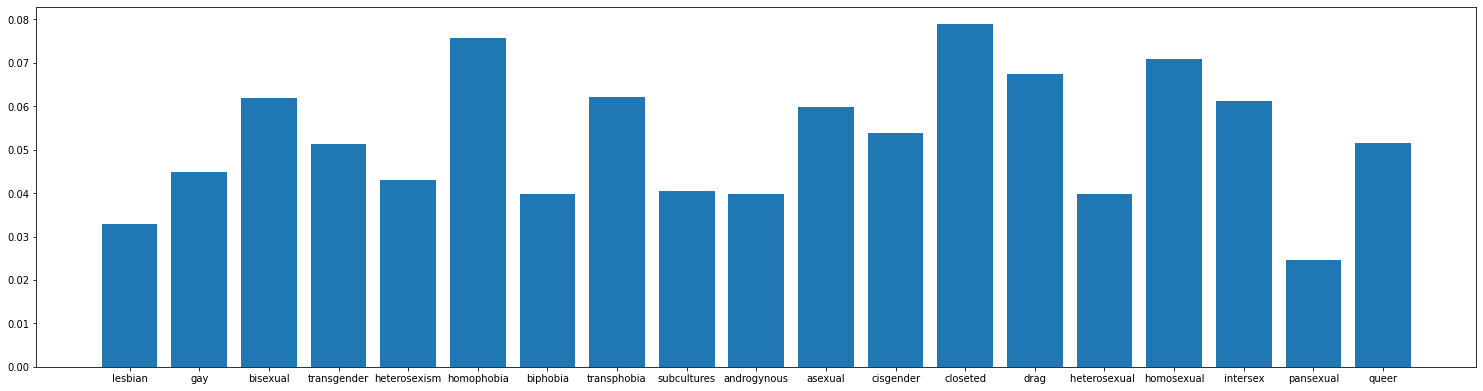

 RNSB =  0.03952687012079728


In [ ]:
# Training the Logistic Regression model and Predicting Negative sentiment for demographic words
neg_association = Negative_Sentiment_Glove(SentiData, label_SentiData, LRmodel="LassoReg")

fig = plt.figure(figsize=(20,5))
ax = fig.add_axes([0,0,1,1])

ax.bar(demo,neg_association)
plt.show()

U = np.array([1/(len(demo))]*len(demo))
P= neg_association
RNSB =  sum(P * np.log(P/U))
print(" RNSB = ", RNSB)

### LassoCV

Lasso Regression CV 
Predictions : 
Demographic word      Negative Sentiment
lesbian                         0.466             
gay                              0.5              
bisexual                        0.814             
transgender                     0.645             
heterosexism                    0.596             
homophobia                      1.029             
biphobia                        0.522             
transphobia                     0.817             
subcultures                     0.624             
androgynous                      0.54             
asexual                         0.696             
cisgender                       0.716             
closeted                        0.957             
drag                            0.814             
heterosexual                    0.522             
homosexual                      0.898             
intersex                        0.842             
pansexual                       0.416             
queer

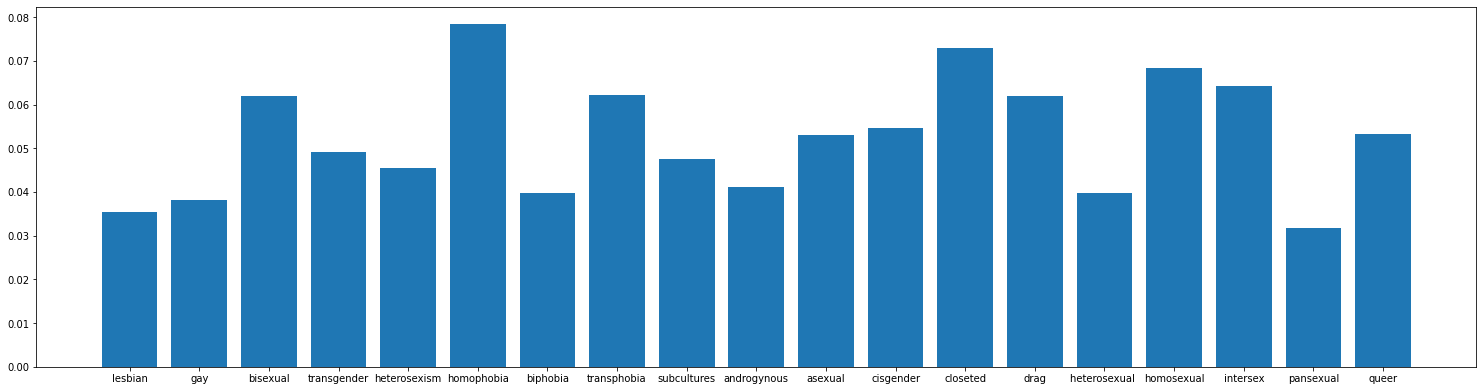

 RNSB =  0.030699297516313874


In [ ]:
# Training the Logistic Regression model and Predicting Negative sentiment for demographic words
neg_association = Negative_Sentiment_Glove(SentiData, label_SentiData, LRmodel="LassoRegCV")


fig = plt.figure(figsize=(20,5))
ax = fig.add_axes([0,0,1,1])

ax.bar(demo,neg_association)
plt.show()

U = np.array([1/(len(demo))]*len(demo))
P= neg_association
RNSB =  sum(P * np.log(P/U))
print(" RNSB = ", RNSB)